## AirB&B Exploratory Data Analysis

In [96]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import folium

### Preliminary exploration


In [97]:
from pyspark.context import SparkContext
import pyspark.sql.functions as func
from pyspark.sql.session import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType


In [98]:
sc = SparkContext("local", "EDA")

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=EDA, master=local) created by __init__ at <ipython-input-3-610433eaf656>:1 

To read and preview dataframe

In [99]:
spark = SparkSession.builder.appName('EDA').getOrCreate()
schema = StructType([
    StructField("neighbourhood", StringType()),
    StructField("latitude", DoubleType()),
    StructField("longitude", DoubleType()),
    StructField("room_type", StringType()),
    StructField("price", IntegerType()),
    StructField("minimum_nights", IntegerType()),
    StructField("availability_365", IntegerType())
])
df = spark.read.csv('MontrealAirB&B_cleaned.csv', header=True, schema=schema)
df.show(5)

+--------------------+-----------+------------+---------------+-----+--------------+----------------+
|       neighbourhood|   latitude|   longitude|      room_type|price|minimum_nights|availability_365|
+--------------------+-----------+------------+---------------+-----+--------------+----------------+
|Le Plateau-Mont-R...|45.53069236| -73.5858783|   Private room|   39|             2|             228|
|        Le Sud-Ouest|45.48441911|-73.57922527|   Private room|   30|             1|             266|
|Le Plateau-Mont-R...|45.54135329| -73.5781392|Entire home/apt|  147|             3|             356|
|         Ville-Marie|45.51888471|-73.56546265|Entire home/apt|   94|             3|             319|
|         Ville-Marie|45.52019501|-73.56421948|Entire home/apt|  145|             4|             363|
+--------------------+-----------+------------+---------------+-----+--------------+----------------+
only showing top 5 rows



Check type of object

In [100]:
type(df)

pyspark.sql.dataframe.DataFrame

Determine how many records

In [101]:
df.count()

19426

Retrieve exact names of columns

In [102]:
df.columns

['neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'availability_365']

We are aiming to get:
- total number of offers, 
- average price of all offers
- average minimum nights
- average price per each type of room
- average minimum nights per each type of room
versus heighbourhood

In [147]:
df_count = df.groupBy("neighbourhood").count()
df_count.show()

avg_price = df.groupBy("neighbourhood").agg({"price" : 'mean'})
# round the price and rename the column
df_avg_price = avg_price.withColumn("avg(price)", func.round(avg_price["avg(price)"], 2)).withColumnRenamed("avg(price)","average_price")
df_avg_price.show()

avg_min_stay = df.groupBy("neighbourhood").agg({"minimum_nights" : 'mean'})
# round the nights and rename the column
df_avg_min_stay = avg_min_stay.withColumn("avg(minimum_nights)", func.round(avg_min_stay["avg(minimum_nights)"], 1)).withColumnRenamed("avg(minimum_nights)","avg_min_stay")
df_avg_min_stay.show()

+--------------------+-----+
|       neighbourhood|count|
+--------------------+-----+
|       Saint-Léonard|   55|
|Rivière-des-Prair...|   68|
|           Hampstead|   23|
|        Montréal-Est|    5|
|              Dorval|   63|
|Le Plateau-Mont-R...| 5616|
|Villeray-Saint-Mi...| 1081|
|Côte-des-Neiges-N...| 1284|
|           Outremont|  271|
|       Saint-Laurent|  173|
| Dollard-des-Ormeaux|   43|
|Ahuntsic-Cartierv...|  310|
|L'Île-Bizard-Sain...|   20|
|              Verdun|  473|
| Pierrefonds-Roxboro|   53|
|           Westmount|  106|
|               Anjou|   53|
|            Kirkland|   10|
|Mercier-Hochelaga...|  925|
|       Pointe-Claire|   53|
+--------------------+-----+
only showing top 20 rows

+--------------------+-------------+
|       neighbourhood|average_price|
+--------------------+-------------+
|       Saint-Léonard|        89.51|
|Rivière-des-Prair...|        211.0|
|           Hampstead|       205.04|
|        Montréal-Est|         33.6|
|              Dorv

In [167]:
# count properties and crosstab
df_cross = df.crosstab('neighbourhood', 'room_type').withColumnRenamed("Entire home/apt","Home (#)").withColumnRenamed("Private room","Private (#)").withColumnRenamed("Shared room","Shared (#)")
df_cross = df_cross.withColumnRenamed("neighbourhood_room_type","neighbourhood")
df_cross.show()

# avg price per type of room in each district - using table pivoting
avg_price = df.groupBy("neighbourhood").pivot('room_type').avg("price")
# round the price and rename the column
df_avg_price2 = avg_price.withColumn("Entire home/apt", func.round(avg_price["Entire home/apt"], 2)).withColumn("Private room", func.round(avg_price["Private room"], 2)).withColumn("Shared room", func.round(avg_price["Shared room"], 2))
df_avg_price2 = df_avg_price2.withColumnRenamed("Entire home/apt","Entire ($)").withColumnRenamed("Private room","Private ($)").withColumnRenamed("Shared room","Shared ($)")


# replace null values by zeros
df_avg_price2 = df_avg_price2.na.fill(0)
df_avg_price2.show()

+--------------------+--------+-----------+----------+
|       neighbourhood|Home (#)|Private (#)|Shared (#)|
+--------------------+--------+-----------+----------+
|Sainte-Anne-de-Be...|       2|          2|         0|
|           Hampstead|      15|          6|         2|
|Villeray-Saint-Mi...|     718|        353|        10|
|          Mont-Royal|      38|         11|         0|
|           Outremont|     167|        101|         3|
|       Saint-Léonard|      39|         16|         0|
|              Dorval|      33|         30|         0|
|       Montréal-Nord|      20|         15|         2|
|         Ville-Marie|    4160|        985|        63|
|             Lachine|      83|         28|         0|
|            Kirkland|       5|          5|         0|
|           Westmount|      72|         34|         0|
|      Montréal-Ouest|       8|          3|         0|
|        Le Sud-Ouest|     757|        360|        10|
|          Senneville|       1|          0|         0|
|         

In [168]:
#merging all 5 created dataframes in one

df_final = df_count.join(df_avg_price, "neighbourhood")
df_final = df_final.join(df_avg_min_stay, "neighbourhood")
df_final = df_final.join(df_avg_price2, "neighbourhood")
df_final = df_final.join(df_cross, "neighbourhood")
df_final.show()

+--------------------+-----+-------------+------------+----------+-----------+----------+--------+-----------+----------+
|       neighbourhood|count|average_price|avg_min_stay|Entire ($)|Private ($)|Shared ($)|Home (#)|Private (#)|Shared (#)|
+--------------------+-----+-------------+------------+----------+-----------+----------+--------+-----------+----------+
|       Saint-Léonard|   55|        89.51|        14.7|    107.49|      45.69|       0.0|      39|         16|         0|
|Rivière-des-Prair...|   68|        211.0|        13.2|    109.03|     322.03|      14.0|      34|         33|         1|
|           Hampstead|   23|       205.04|        10.1|    291.93|      50.17|      18.0|      15|          6|         2|
|        Montréal-Est|    5|         33.6|         6.8|      39.0|      32.25|       0.0|       1|          4|         0|
|              Dorval|   63|       125.95|         7.5|    181.45|       64.9|       0.0|      33|         30|         0|
|Le Plateau-Mont-R...| 5

In [169]:
# filter out neighbours having less than 10 offers on AirBnB
df_final.filter(df_final['count'] > 10).show()

+--------------------+-----+-------------+------------+----------+-----------+----------+--------+-----------+----------+
|       neighbourhood|count|average_price|avg_min_stay|Entire ($)|Private ($)|Shared ($)|Home (#)|Private (#)|Shared (#)|
+--------------------+-----+-------------+------------+----------+-----------+----------+--------+-----------+----------+
|       Saint-Léonard|   55|        89.51|        14.7|    107.49|      45.69|       0.0|      39|         16|         0|
|Rivière-des-Prair...|   68|        211.0|        13.2|    109.03|     322.03|      14.0|      34|         33|         1|
|           Hampstead|   23|       205.04|        10.1|    291.93|      50.17|      18.0|      15|          6|         2|
|              Dorval|   63|       125.95|         7.5|    181.45|       64.9|       0.0|      33|         30|         0|
|Le Plateau-Mont-R...| 5616|       118.64|         6.6|    139.05|      73.42|     35.56|    3884|       1707|        25|
|Villeray-Saint-Mi...| 1

In [170]:
#Save data to file
df_final.toPandas().to_csv('MontrealAirB&B_cleaned_processed.csv')

#### Descriptive analytics. Simple visualization.

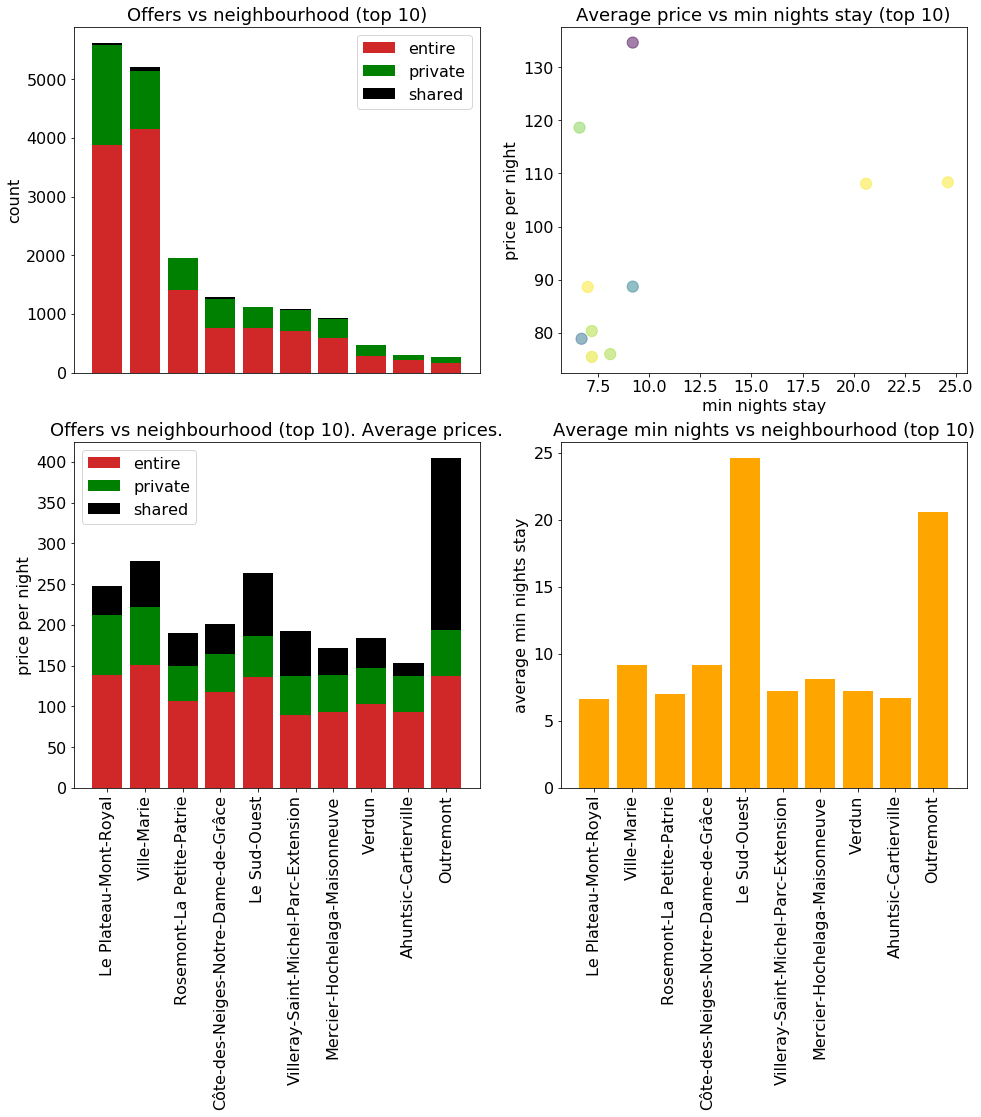

In [171]:
plt.figure(figsize=(16, 14))

# convert to Pandas Dataframe
fd1 = df_final.toPandas()

#take first 10 districts based on the number of offers
fd1 = fd1.nlargest(10,"count")

#left top plot
plt.subplot(221)

entire = fd1["Home (#)"]
private = fd1["Private (#)"]
shared = fd1["Shared (#)"]

ind = np.arange(10)  

p1 = plt.bar(ind, entire, color='#d02728')
p2 = plt.bar(ind, private,  bottom=entire, color='green')
p3 = plt.bar(ind, shared, bottom=entire+private, color='black')

plt.ylabel('count', fontsize=16)
plt.xticks([], fontsize=16)
plt.yticks(fontsize=16)
plt.title("Offers vs neighbourhood (top 10)", fontsize=18)
plt.legend((p1[0], p2[0], p3[0]), ('entire', 'private', "shared"), fontsize=16)

# left bottom plot
plt.subplot(223)

entire = fd1["Entire ($)"]
private = fd1["Private ($)"]
shared = fd1["Shared ($)"]

ind = np.arange(10)  

p1 = plt.bar(ind, entire, color='#d02728')
p2 = plt.bar(ind, private,  bottom=entire, color='green')
p3 = plt.bar(ind, shared, bottom=entire+private, color='black')

plt.ylabel('price per night', fontsize=16)
plt.xticks(ind, fd1["neighbourhood"], fontsize=16, rotation=90)
plt.yticks(fontsize=16)

plt.title("Offers vs neighbourhood (top 10). Average prices.", fontsize=18)
plt.legend((p1[0], p2[0], p3[0]), ('entire', 'private', "shared"), fontsize=16)

# top right plot
plt.subplot(222)

colors = np.random.rand(10)
ax3 = plt.scatter(fd1["avg_min_stay"], fd1["average_price"], s = 125, c = colors, alpha=0.5)
plt.title("Average price vs min nights stay (top 10)", fontsize=18)
plt.ylabel('price per night', fontsize=16)
plt.xlabel('min nights stay', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


#bottom right plot
plt.subplot(224)

ax4=plt.bar(fd1["neighbourhood"], fd1["avg_min_stay"], align='center', color="orange")
plt.xticks(rotation="vertical", fontsize=16)
plt.title("Average min nights vs neighbourhood (top 10)", fontsize=18)
plt.ylabel('average min nights stay', fontsize=16)
plt.yticks(fontsize=16)


plt.show()

Placing some data on the georaphical map (placing all data takes too much processing time/memory)

In [172]:
# convert to Pandas Dataframe
df = df.toPandas()

locations = df[['latitude', 'longitude']]
locationlist = locations.values.tolist()

map = folium.Map(location=[45.5017, -73.5673], zoom_start=13) #coordinates of Montreal
# map
for point in range(0, len(locationlist)-19350):
    folium.Marker(locationlist[point], popup=df['neighbourhood'][point]).add_to(map)
map

<font color=blue>***Current project will be focused on the use case concerning prediction of the price per night of renting property on AirBnB. Prediction will be based on analysis of property location, type of room and minimum nights stay. Application that estimates the renting price can be useful both for hosts who are willing to use AirBnB service and for users of AirBnB service when they need to estimate thier budget for accomodation based on search criteria.***</font>